![](img/cluster_img.jpg)

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("K-means") \
    .getOrCreate()

In [94]:
# все импорты

from pyspark.mllib.linalg import Vectors

from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.clustering import KMeans
from functools import reduce  # For Python 3.x
from pyspark.ml.evaluation import ClusteringEvaluator

import time

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col, percent_rank, lit
from pyspark.sql.window import Window
from pyspark.sql import DataFrame, Row
from pyspark.sql.types import StructType
from functools import reduce  # For Python 3.x

In [29]:
# Spark оптимизаторы PyArrow

# !pip install pyarrow
# иначе будет Warning - Attempting non-optimization ...

spark.conf.set("spark.sql.execution.arrow.enabled", "true")
spark.conf.set("spark.sql.execution.arrow.fallback.enabled", "true")

In [70]:
import pandas as pd
import numpy as np
from sklearn import datasets
iris = datasets.load_iris()

In [31]:
pdf = pd.DataFrame(data = iris['data'], columns = iris['feature_names'])
pdf['target'] = iris['target']
pdf.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [32]:
df = spark.createDataFrame(pdf)
df.show(5)

+-----------------+----------------+-----------------+----------------+------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|target|
+-----------------+----------------+-----------------+----------------+------+
|              5.1|             3.5|              1.4|             0.2|     0|
|              4.9|             3.0|              1.4|             0.2|     0|
|              4.7|             3.2|              1.3|             0.2|     0|
|              4.6|             3.1|              1.5|             0.2|     0|
|              5.0|             3.6|              1.4|             0.2|     0|
+-----------------+----------------+-----------------+----------------+------+
only showing top 5 rows



In [34]:
df.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary| sepal length (cm)|  sepal width (cm)| petal length (cm)|  petal width (cm)|            target|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|               150|               150|               150|               150|               150|
|   mean| 5.843333333333334|3.0573333333333337|3.7580000000000005|1.1993333333333331|               1.0|
| stddev|0.8280661279778637|0.4358662849366982|1.7652982332594664|0.7622376689603465|0.8192319205190406|
|    min|               4.3|               2.0|               1.0|               0.1|                 0|
|    max|               7.9|               4.4|               6.9|               2.5|                 2|
+-------+------------------+------------------+------------------+------------------+------------------+



In [36]:
# данные в вектор
def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1])]).toDF(['features'])

In [39]:
transformed= transData(df)
transformed.show(5, False)

+-----------------+
|features         |
+-----------------+
|[5.1,3.5,1.4,0.2]|
|[4.9,3.0,1.4,0.2]|
|[4.7,3.2,1.3,0.2]|
|[4.6,3.1,1.5,0.2]|
|[5.0,3.6,1.4,0.2]|
+-----------------+
only showing top 5 rows



In [60]:
# Автоматически определяем категории и индексируем их 
# в таргете 4 категории, определяем, что в данных не больше 4х
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4)\
                    .fit(transformed)

# и получим ошибку
data = featureIndexer.transform(transformed)

IllegalArgumentException: requirement failed: Column features must be of type struct<type:tinyint,size:int,indices:array<int>,values:array<double>> but was actually struct<type:tinyint,size:int,indices:array<int>,values:array<double>>.

In [61]:
# но значения одинаковые
# struct<type:tinyint,size:int,indices:array<int>,values:array<double>>
# struct<type:tinyint,size:int,indices:array<int>,values:array<double>>

In [64]:
# соберем по другому
vect = VectorAssembler().setInputCols(df.columns[:-1]).setOutputCol('features')
transformed = vect.transform(df).select('features', 'target')
transformed.show(5)

+-----------------+------+
|         features|target|
+-----------------+------+
|[5.1,3.5,1.4,0.2]|     0|
|[4.9,3.0,1.4,0.2]|     0|
|[4.7,3.2,1.3,0.2]|     0|
|[4.6,3.1,1.5,0.2]|     0|
|[5.0,3.6,1.4,0.2]|     0|
+-----------------+------+
only showing top 5 rows



In [68]:
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4)\
                    .fit(transformed)

# и все работает
data = featureIndexer.transform(transformed)
data.show(5)

+-----------------+------+-----------------+
|         features|target|  indexedFeatures|
+-----------------+------+-----------------+
|[5.1,3.5,1.4,0.2]|     0|[5.1,3.5,1.4,0.2]|
|[4.9,3.0,1.4,0.2]|     0|[4.9,3.0,1.4,0.2]|
|[4.7,3.2,1.3,0.2]|     0|[4.7,3.2,1.3,0.2]|
|[4.6,3.1,1.5,0.2]|     0|[4.6,3.1,1.5,0.2]|
|[5.0,3.6,1.4,0.2]|     0|[5.0,3.6,1.4,0.2]|
+-----------------+------+-----------------+
only showing top 5 rows



In [86]:
# обучим и применим "метод плеча"

n_rounds=20
cost = np.zeros(n_rounds)
for k in range(2,n_rounds):
    kmeans = KMeans()\
            .setK(k)\
            .setSeed(1) \
            .setFeaturesCol("indexedFeatures")\
            .setPredictionCol("prediction")

    model = kmeans.fit(data)
   
    predictions = model.transform(data)    
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(model.transform(data))
    cost[k] = silhouette
    print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.850351222925148
Silhouette with squared euclidean distance = 0.7344130579787835
Silhouette with squared euclidean distance = 0.6750445984283666
Silhouette with squared euclidean distance = 0.5975363464982316
Silhouette with squared euclidean distance = 0.5092028210711426
Silhouette with squared euclidean distance = 0.5041199363597769
Silhouette with squared euclidean distance = 0.5122305088331657
Silhouette with squared euclidean distance = 0.604760985138322
Silhouette with squared euclidean distance = 0.5847553016050858
Silhouette with squared euclidean distance = 0.44627017569488486
Silhouette with squared euclidean distance = 0.43546212780855387
Silhouette with squared euclidean distance = 0.40671574372717767
Silhouette with squared euclidean distance = 0.3880890062590612
Silhouette with squared euclidean distance = 0.36170561250817834
Silhouette with squared euclidean distance = 0.40730957127256334
Silhouette with squared euclidean dis

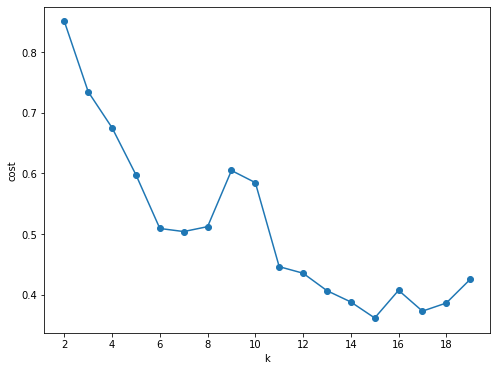

In [87]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,n_rounds),cost[2:n_rounds], marker = "o")
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [88]:
def optimal_k(df_in,index_col,k_min, k_max,num_runs):
    '''
    Determine optimal number of clusters by using Silhoutte Score Analysis.
    :param df_in: the input dataframe
    :param index_col: the name of the index column
    :param k_min: the train dataset
    :param k_min: the minmum number of the clusters
    :param k_max: the maxmum number of the clusters
    :param num_runs: the number of runs for each fixed clusters

    :return k: optimal number of the clusters
    :return silh_lst: Silhouette score
    :return r_table: the running results table

    :author: Wenqiang Feng
    :email:  von198@gmail.com
    '''

    start = time.time()
    silh_lst = []
    k_lst = np.arange(k_min, k_max+1)

    r_table = df_in.select(index_col).toPandas()
    r_table = r_table.set_index(index_col)
    centers = pd.DataFrame()

    for k in k_lst:
        silh_val = []
        for run in np.arange(1, num_runs+1):

            # Trains a k-means model.
            kmeans = KMeans()\
                    .setK(k)\
                    .setSeed(int(np.random.randint(100, size=1)))
            model = kmeans.fit(df_in)

            # Make predictions
            predictions = model.transform(df_in)
            r_table['cluster_{k}_{run}'.format(k=k, run=run)]= predictions.select('prediction').toPandas()

            # Evaluate clustering by computing Silhouette score
            evaluator = ClusteringEvaluator()
            silhouette = evaluator.evaluate(predictions)
            silh_val.append(silhouette)

        silh_array=np.asanyarray(silh_val)
        silh_lst.append(silh_array.mean())

    elapsed =  time.time() - start

    silhouette = pd.DataFrame(list(zip(k_lst,silh_lst)),columns = ['k', 'silhouette'])

    print('+------------------------------------------------------------+')
    print("|         The finding optimal k phase took %8.0f s.       |" %(elapsed))
    print('+------------------------------------------------------------+')


    return k_lst[np.argmax(silh_lst, axis=0)], silhouette , r_table

In [93]:
k, silh_lst, r_table = optimal_k(data, 'indexedFeatures', 6, 15, 20)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/pandas/conversion.py:88: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


+------------------------------------------------------------+
|         The finding optimal k phase took      138 s.       |
+------------------------------------------------------------+


In [99]:
silh_lst

,k,silhouette
0,6,0.575430
1,7,0.526598
2,8,0.537135
3,9,0.515312
4,10,0.498141
5,11,0.469991
6,12,0.447016
7,13,0.434067
8,14,0.420816
9,15,0.406164


In [101]:
kmeans = KMeans() \
          .setK(k) \
          .setFeaturesCol("indexedFeatures")\
          .setPredictionCol("prediction")

# создаем последовательность
pipeline = Pipeline(stages=[featureIndexer, kmeans])

model = pipeline.fit(transformed)

cluster = model.transform(transformed)

In [102]:
cluster = model.transform(transformed)

In [103]:
cluster.show(5)

+-----------------+------+-----------------+----------+
|         features|target|  indexedFeatures|prediction|
+-----------------+------+-----------------+----------+
|[5.1,3.5,1.4,0.2]|     0|[5.1,3.5,1.4,0.2]|         1|
|[4.9,3.0,1.4,0.2]|     0|[4.9,3.0,1.4,0.2]|         5|
|[4.7,3.2,1.3,0.2]|     0|[4.7,3.2,1.3,0.2]|         5|
|[4.6,3.1,1.5,0.2]|     0|[4.6,3.1,1.5,0.2]|         5|
|[5.0,3.6,1.4,0.2]|     0|[5.0,3.6,1.4,0.2]|         1|
+-----------------+------+-----------------+----------+
only showing top 5 rows

